<a href="https://colab.research.google.com/github/eduardomdalmaso/news_2016/blob/main/Eduardo_Projeto_de_Disciplina_de_Text_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Disciplina de Processamento de Linguagem Natural com Python

Bem-vindo ao projeto de disciplina de **Processamento de Linguagem Natural com Python**. Ao longo das últimas aulas vimos uma série de aplicações que nos deram a amplitude de possibilidades em trabalhar com textos. Para tal, usamos diversas bibliotecas, onde as que mais se destacaram foram NLTK, SPACY e GENSIM.

Esse notebook servirá de guia para a execução de uma análise de tópicos completa, usando o algoritmo de LDA e recursos para interpretação dos resultados. Utilizaremos notícias da seção "Mercado" extraídas da Folha de S. Paulo no ano de 2016.  Complete a análise com os códigos que achar pertinente e responda as questões presentes no Moodle. Boa sorte!

## O Notebook

Nesse notebook, você será guiado pela análise de **Extração de Tópicos**. As seguintes tarefas serão realizadas


1.   Download dos dados provenientes do kaggle
2.   Seleção dos dados relevantes para a nossa análise
3.   Instalação das principais ferramentas e importação de módulos
4.   Pré-processamento usando NLTK
5.   Pré-processamento usando Spacy
6.   Análise de tópicos usando LDA
7.   Análise de NER usando Spacy
8.   Visualização dos tópicos usando tokens e entidades.



## Instruções para baixar os dados

Para baixar os dados será necessário o uso do gerenciador de downloads da Kaggle. A Kaggle, uma subsidiária do grupo Alphabet (Google), é uma comunidade on-line de cientistas de dados e profissionais de aprendizado de máquina.

Para utilizar o gerenciador, será necessário criar uma conta no site Kaggle.com.
Com a conta criada, obtenha um token de acesso, no formato kaggle.json

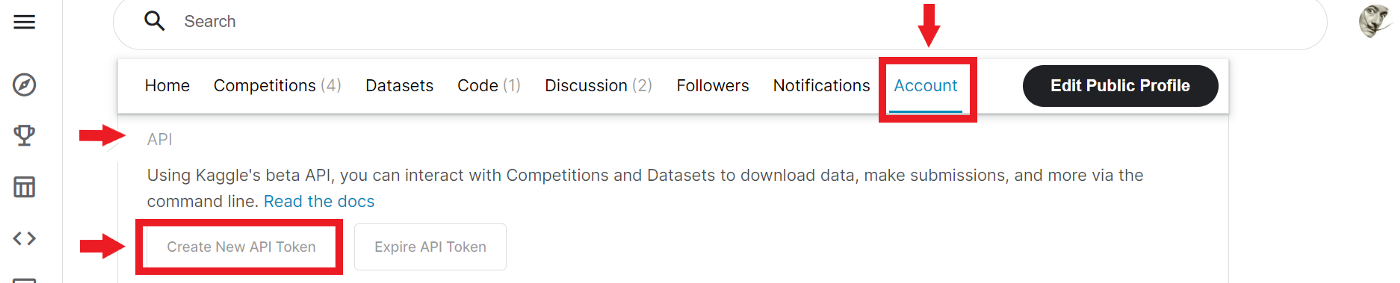

Em posse do token (baixe para seu computador), execute a células da próxima seção para acessar os dados de interesse e baixá-los.

# Baixe os dados

Instale o gerenciador kaggle no ambiente do Colab e faça o upload do arquivo kaggle.json

In [1]:
#CELL1
!pip install -q kaggle
!rm -rf kaggle.json
from google.colab import files

files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"eduardomd","key":"8c0c183375bf0d02968cdb2cef0c9cf9"}'}

Crie a pasta .kaggle

In [2]:
#CELL2
!rm -rf .kaggle
!mkdir .kaggle
!cp kaggle.json .kaggle/
!chmod 600 .kaggle/kaggle.json

Baixe o dataset

In [3]:
#CELL3
!kaggle datasets download --force -d marlesson/news-of-the-site-folhauol

Dataset URL: https://www.kaggle.com/datasets/marlesson/news-of-the-site-folhauol
License(s): CC0-1.0
 97% 182M/187M [00:01<00:00, 165MB/s]
100% 187M/187M [00:01<00:00, 140MB/s]


## Criar o DataFrame com os dados lidos diretamente da plataforma Kaggle

In [4]:
#CELL4
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()


df = pd.read_csv("news-of-the-site-folhauol.zip")

# Atualizar o SPACY e  instalar os modelos pt_core_news_lg

In [5]:
#CELL5
# Escreva seu código aqui
!pip install spacy &> /dev/null
!pip install --upgrade spacy &> /dev/null
!python -m spacy download pt_core_news_lg &> /dev/null

import spacy
from spacy.lang.pt.stop_words import STOP_WORDS

## Instalar os datasets `stopwords`, `punkt` e `rslp` do nltk

In [6]:
#CELL6
import nltk

# Escreva seu código aqui
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


True

## Carregar os módulos usados ao longo desse notebook

In [7]:
#CELL7
!pip uninstall pyLDAvis
!pip install --upgrade git+https://github.com/bmabey/pyLDAvis.git &> /dev/null

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import numpy as np

import pyLDAvis
import pyLDAvis.lda_model

from wordcloud import WordCloud

import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain

from typing import List, Set, Any


SEED = 123

# Filtrando os dados para utilizar apenas as notícias do ano de 2016 e da categoria "Mercado"

Filtre os dados do DataFrame df e crie um DataFrame news_2016 que contenha apenas notícias de **2016** e da categoria **mercado**.

In [8]:
#CELL8
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,title,text,date,category,subcategory,link
0,"Lula diz que está 'lascado', mas que ainda tem...",Com a possibilidade de uma condenação impedir ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
1,"'Decidi ser escrava das mulheres que sofrem', ...","Para Oumou Sangaré, cantora e ativista malines...",2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
2,Três reportagens da Folha ganham Prêmio Petrob...,Três reportagens da Folha foram vencedoras do ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
3,Filme 'Star Wars: Os Últimos Jedi' ganha trail...,A Disney divulgou na noite desta segunda-feira...,2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
4,CBSS inicia acordos com fintechs e quer 30% do...,"O CBSS, banco da holding Elopar dos sócios Bra...",2017-09-10,mercado,NaN,http://www1.folha.uol.com.br/mercado/2017/10/1...


In [9]:
#CELL9
df['date'] = pd.to_datetime(df.date)
# Create a dataframe named news_2016
news_2016 = df[(df['category'] == 'mercado') & (df['date'].dt.year == 2016)]
news_2016

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,title,text,date,category,subcategory,link
34207,Fazendeira cria própria rede de banda larga e ...,"""Sou apenas a mulher de um fazendeiro"", diz Ch...",2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...
34238,Alteração na cobrança do ICMS eleva conta de c...,A conta do celular pós-pago ou controle ficará...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...
34245,Ajustes sobre servidores públicos emperram nos...,A maior parte dos projetos de ajuste das conta...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...
34248,Inventor da internet das coisas ataca mitos so...,Desde as primeiras décadas do século 19 se diz...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...
34249,Livro analisa empresas de crescimento exponenc...,O Cifras & Letras seleciona semanalmente lança...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...
...,...,...,...,...,...,...
94280,Previsões para economia dependem de rumos do g...,"Para o economista Rodolfo Margato, do banco Sa...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...
94295,Repelentes e água de coco lideram a lista de s...,"Conveniência, saúde, boa forma e prazer. As te...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...
94301,Renda em queda leva mais pessoas às filas de e...,"Com o rendimento em queda, mais pessoas são fo...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...
94310,"Brasil pode perder até 2,2 milhões de vagas fo...","O Brasil pode perder até 2,2 milhões de vagas ...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...


## NLTK Tokenizer and Stemmer

Crie uma coluna no dataframe `news_2016` contendo os tokens para cada um dos textos. Os tokens devem estar representados pelo radical das palavras (stem).
Para tal, complete o conteúdo da função `tokenize`.

In [10]:
#CELL110
from nltk.stem import RSLPStemmer
from nltk.tokenize import word_tokenize

def tokenize(text: str) -> List:
  """
  Function for tokenizing using `nltk.tokenize.word_tokenize`

  Returns:
    - A list of stemmed tokens (`nltk.stem.RSLPStemmer`)
    IMPORTANT: Only tokens with alphabetic
               characters will be returned.
  """
  #escreva seu código aqui
  stemmer = RSLPStemmer()
  tokens = word_tokenize(text)
  stemmed_tokens = [stemmer.stem(token) for token in tokens if token.isalpha()]

  return stemmed_tokens

news_2016.loc[:, 'nltk_tokens'] = news_2016.text.progress_map(tokenize)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/7943 [00:00<?, ?it/s]

## Criar uma documento SPACY para cada texto do dataset

Crie uma coluna `spacy_doc` que contenha os objetos spacy para cada texto do dataset de interesse. Para tal, carregue os modelos `pt_core_news_lg` e aplique em todos os textos (pode demorar alguns minutos...)

In [11]:
#CELL11
# Escreva seu código aqui
import spacy

nlp = spacy.load("pt_core_news_lg")

def spacynator(text: str) -> List:
  doc = nlp(text)

  return doc

news_2016.loc[:, 'spacy_doc'] = news_2016.text.progress_map(spacynator)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/7943 [00:00<?, ?it/s]

## Realize a Lematização usando SPACY

O modelo NLP do spacy oferece a possiblidade de lematizar textos em português (o que não acontece com a biblioteca NLTK). Iremos criar uma lista de tokens
lematizados para cada texto do nosso dataset. Para tal, iremos retirar as
stopwords, usando uma função que junta stopwords provenientes do NLTK e do Spacy. Essa lista completa, é retornada pela função stopwords (e você não precisa mexer).

Já a função filter retorna True caso o token seja composto por caracters alfabéticos, não estiver dentro da lista de stopwords e o lemma resultante não estiver contido na lista `o", "em", "em o", "em a" e "ano"`.

Crie uma coluna chamada `spacy_lemma` para armazenar o resultado desse pré-processamento.

In [12]:
#CELL12
def stopwords() -> Set:
    """
    Return complete list of stopwords
    """
    return set(list(nltk.corpus.stopwords.words("portuguese")) + list(STOP_WORDS))

complete_stopwords = stopwords()

def filter(w: spacy.lang.pt.Portuguese) -> bool:
    """
    Filter stopwords and undesired tokens
    """
    if not w.is_alpha:
      return True

    if w.lemma_ in complete_stopwords:
      return True

    if w.lemma_ in ["o", "em", "em o", "em a", "ano"]:
      return True


def lemma(doc: spacy.lang.pt.Portuguese) -> List[str]:
    """
    Apply spacy lemmatization on the tokens of a text

    Returns:
       - a list representing the standardized (with lemmatisation) vocabulary
    """
    # Escreva seu cógigo aqui
    lemmatized_tokens = [token.lemma_ for token in doc if filter(token)]

    return lemmatized_tokens

news_2016.loc[:, 'spacy_lemma'] = news_2016.spacy_doc.progress_map(lemma)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/7943 [00:00<?, ?it/s]

## Reconhecimento de entidades nomeadas

Crie uma coluna `spacy_ner` que armazene todas as organizações (APENAS organizações) que estão contidas no texto.

In [13]:
#CELL13
def NER(doc: spacy.lang.pt.Portuguese):
  """
  Return the list of organizations for a SPACY document
  """
  # Escreva seu código aqui
  organizacoes = []
  for ent in doc.ents:
    if ent.label_ == "ORG":
      organizacoes.append(ent.text)
  return organizacoes

news_2016.loc[:, 'spacy_ner'] = news_2016.spacy_doc.progress_map(NER)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/7943 [00:00<?, ?it/s]

## Bag-of-Words

Crie uma coluna `tfidf` no dataframe `news_2016`. Use a coluna `spacy_lemma` como base para cálculo do TFIDF.
O número máximo de features que iremos considerar é 5000. E o token, tem que ter aparecido pelo menos 10 vezes (`min_df`) nos documentos.

In [14]:
#CELL14
class Vectorizer:
  def __init__(self, doc_tokens: List):
    self.doc_tokens = doc_tokens
    self.tfidf = None

  def vectorizer(self):
      """
      Convert a list of tokens to tfidf vector
      Returns the tfidf vector and attribute it to self.tfidf
      """
      #código aqui
      doc_strings = [' '.join(tokens) for tokens in self.doc_tokens]
      self.tfidf = TfidfVectorizer(max_features=5000, min_df=10)
      self.tfidf.fit(doc_strings)

  def __call__(self):
    if self.tfidf is None:
        self.vectorizer()
    return self.tfidf

doc_tokens = news_2016.spacy_lemma.values.tolist()
vectorizer = Vectorizer(doc_tokens)

def tokens2tfidf(tokens):
  tokens = ' '.join(tokens)
  array =  vectorizer().transform([tokens]).toarray()[0]
  return array

news_2016.loc[:, 'tfidf'] = news_2016.spacy_lemma.progress_map(tokens2tfidf)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/7943 [00:00<?, ?it/s]

## Extração de Tópicos

Realize a extração de 9 tópicos usando a implementação do sklearn do algoritmo Latent Dirichlet Allocation. Como parâmetros, você irá usar o número máximo de iterações igual à 100 (pode demorar) e o `random_seed` igual a `SEED` que foi setado no início do notebook

In [32]:
#CELL15
N_TOKENS = 9
max_iter = 100
random_state = SEED

corpus = np.array(news_2016.tfidf.tolist())
#Escreva seu código aqui
#lda = ... (complete)
lda_model = LDA(n_components=N_TOKENS, max_iter=max_iter, random_state=random_state)
lda_model.fit(corpus)
lda = lda_model.transform(corpus)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Visualize os tópicos usando a ferramenta pyLDAVis

In [127]:
#CELL16
# Escreva seu código aqui
for idx_topic in range(lda_model.components_.shape[0]):
  top_token_idxs = lda_model.components_[idx_topic, :].argsort()[-10:]
  top_token_idxs = top_token_idxs[::-1]
  print()
  print(f"Tópico {idx_topic}")
  print(f"==========")

  for idx_token in top_token_idxs:
    print(f'{doc_strings[idx_token]:10s} : {lda_model.components_[idx_topic, idx_token]}')


Tópico 0
o de de em o o de em o quinta-feira ( 24 ) . em o , o em , enquanto o .   em o segundo sem qualquer em o , o o em de 0,09 % , a R$ 3,3963 . já o 0,05 % , a R$ 3,3950 .   em o , o grande parte , com o ainda de que haver um mais a partir ano que .   em o de , o perto em o mais e em em o de .   o ( ) , de contra e de de , 0,27 % , 307 ponto .     o em em o grande parte e com de 0,95 % , 61.395,53 ponto . o ser de R$ 3,3 , menos quarta-feira ( 23 ) .   o de o de grande , com +6,02 % , o R$ 57,70 , após o conselho de ter o para de seu de 43,3 % em o .   fora , o 14,28 % , a R$ 9,44 , com de em o .   o 1,70 % , mas o 1,34 % . em o , o próximo .   o 1,78 % ( ) e 2,95 % ( ) , mesmo com o em o terceiro .   em o , 1,04 % ; , -0,94 % ; , -1,13 % ; , -2,67 % ; , -2,04 % ; e BM&FBovespa , +0,24 % . : 12.515205722171702
o ( ) , , o de um que o , em o , que o estado .   , ( ) , e que fazer parte para o estado , o 30 % e menos em o próximo 16 mês .   o ter como o , apontar para o estado . co

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Atribua a cada text, um (e apenas um) tópic.

Crie uma coluna `topic` onde o valor é exatamente o tópico que melhor caracteriza o documento de acordo com o algoritmo de LDA.

In [38]:
#CELL17
def get_topic(tfidf: np.array)->int:
    """
    Get topic for a lda trained model
    """
    # Escreva seu código aqui
    topic_probs = lda_model.transform([tfidf])[0]
    return np.argmax(topic_probs)

news_2016['topic'] = news_2016.tfidf.progress_map(get_topic)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/7943 [00:00<?, ?it/s]

## Número de documentos vs tópicos

Esse gráfico nos mostra quantos documentos foram caracterizados por cada tópico.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


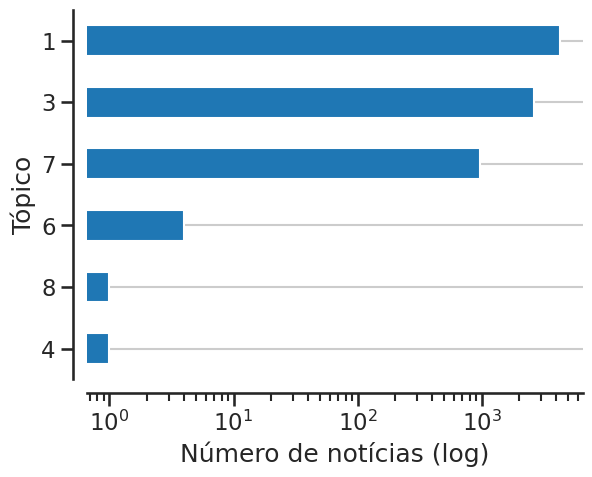

In [40]:
#CELL18
with sns.axes_style("ticks"):
    sns.set_context("talk")
    ax = news_2016['topic'].value_counts().sort_values().plot(kind = 'barh')
    ax.yaxis.grid(True)
    ax.set_ylabel("Tópico")
    ax.set_xlabel("Número de notícias (log)")
    sns.despine(offset = 10)
    ax.set_xscale("log")

## Crie uma nuvem de palavra para cada tópico.

Use as colunas `spacy_lemma` e  `topic` para essa tarefa.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


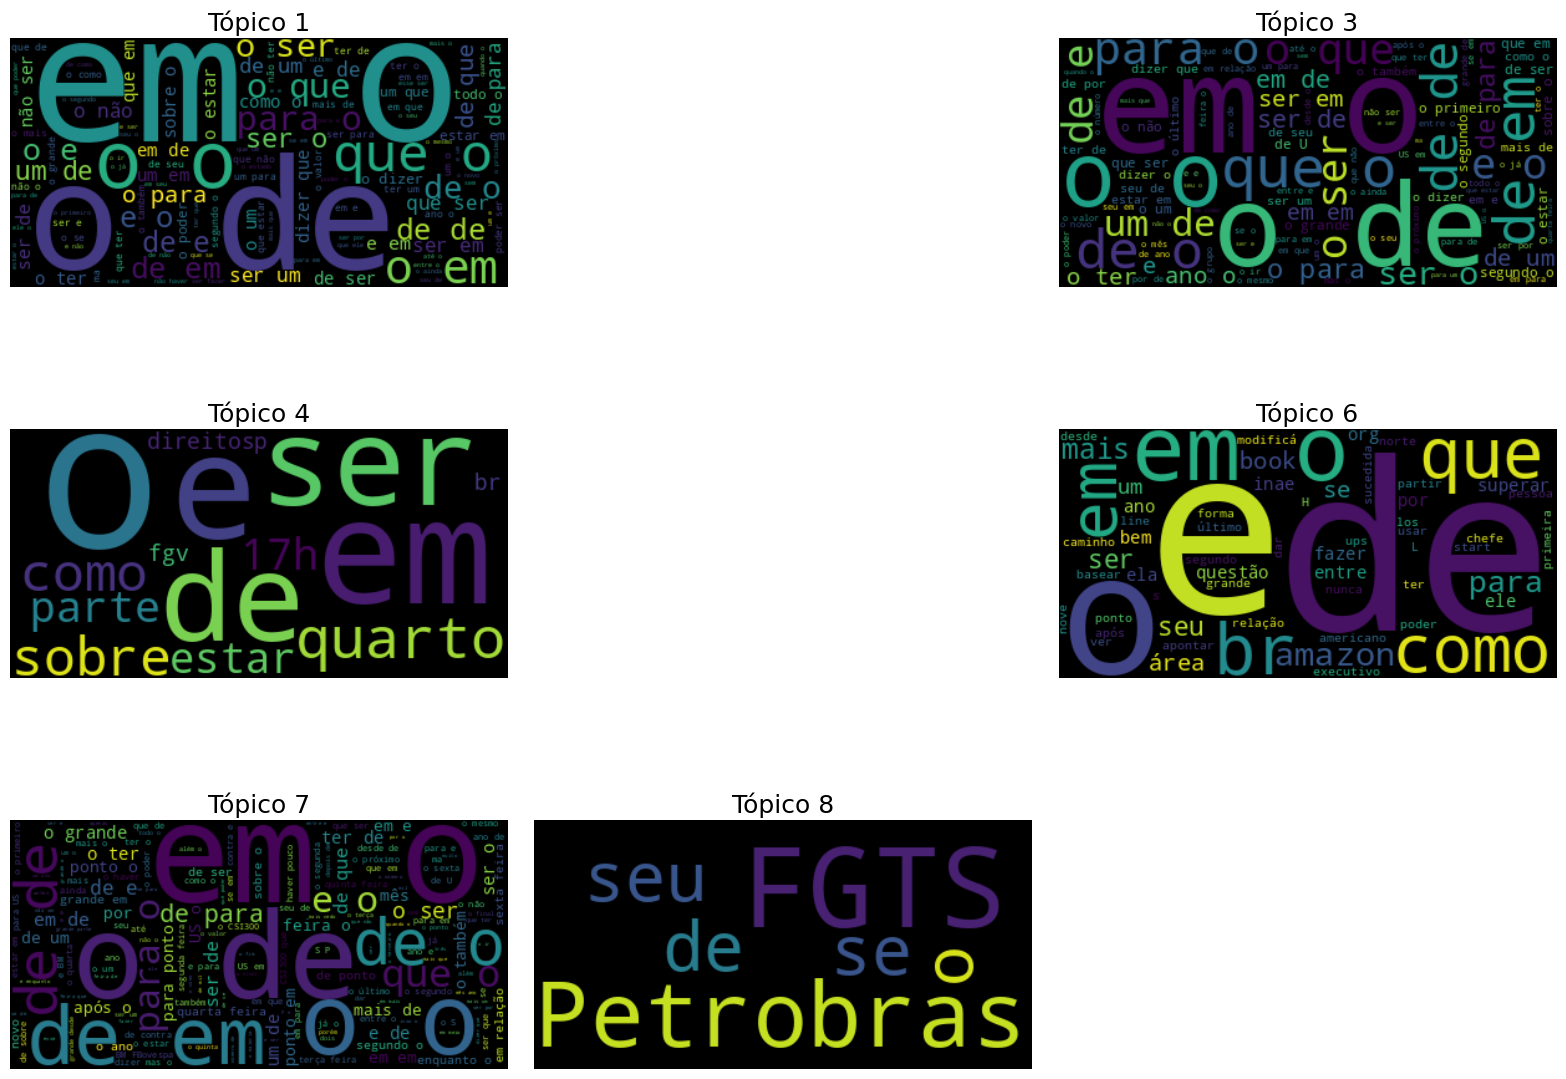

In [125]:
#CELL19
def plot_wordcloud(text:str, ax:plt.Axes) -> plt.Axes:
    """
    Plot the wordcloud for the text/
    Arguments:
        -  text: string to be analised
        -  ax: plt subaxis
    Returns:
     - ax
    """
    # Escreva seu código aqui
    #stopwords = set(STOP_WORDS)
    wordcloud = WordCloud().generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    return ax

def plot_wordcloud_for_a_topic(topic:int, ax:plt.Axes) -> plt.Axes:
    topic_news = news_2016[news_2016['topic'] == topic]
    list_of_words = chain(*topic_news.spacy_lemma.values.tolist())
    string_complete = ' '.join(list_of_words)
    if not string_complete:
        return None
    return plot_wordcloud(string_complete, ax)

fig, axis = plt.subplots(3, 3, figsize=(16, 12))

axis_  = axis.flatten()
for idx, ax in enumerate(axis_):
    ax_ = plot_wordcloud_for_a_topic(idx + 1, ax)
    if ax_ is None:
        plt.delaxes(ax)
        continue
    ax.set_title(f"Tópico {idx + 1}")
fig.tight_layout()

Crie uma nuvem de entidades para cada tópico.
Use as colunas spacy_lemma e topic para essa tarefa.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


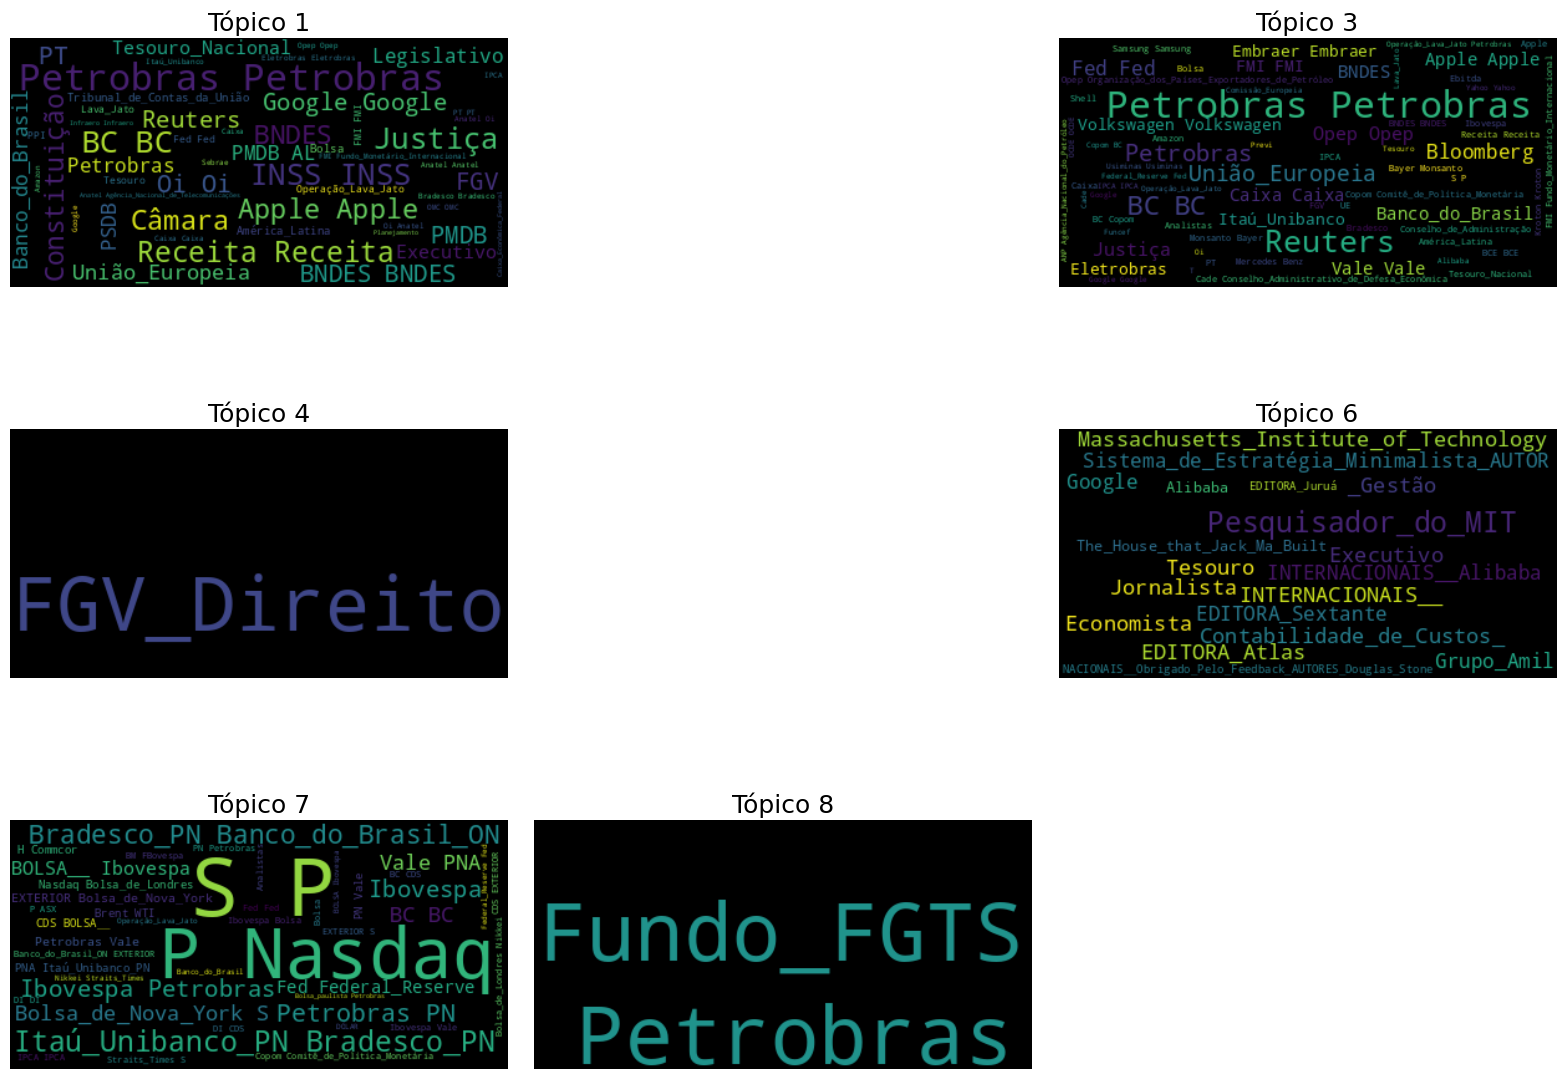

In [129]:
def plot_wordcloud_entities_for_a_topic(topic:int, ax:plt.Axes) -> plt.Axes:
    topic_news = news_2016[news_2016['topic'] == topic]
    list_of_docs = topic_news.spacy_ner.apply(lambda l : [w.replace(" ", "_") for w in l])
    list_of_words = chain(*list_of_docs)
    string_complete = ' '.join(list_of_words)
    if not len(string_complete):
        return None
    return plot_wordcloud(string_complete, ax)

fig, axis = plt.subplots(3, 3, figsize=(16, 12))

axis_  = axis.flatten()
for idx, ax in enumerate(axis_):
    ax_ = plot_wordcloud_entities_for_a_topic(idx + 1, ax)
    if ax_ is None:
        plt.delaxes(ax)
        continue
    ax.set_title(f"Tópico {idx + 1}")
fig.tight_layout()